<a href="https://colab.research.google.com/github/x200706/AIML/blob/main/ML/GARastrigin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

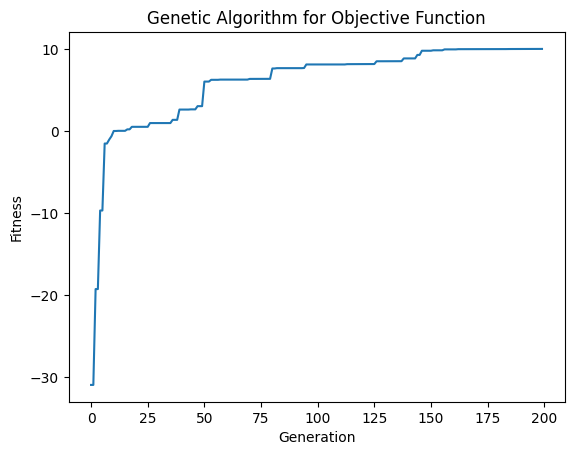

Best Individual: [0.0048824775230329465, -0.005788067580617451, -0.00034861445435030447, 0.0014102900031511822, -0.002596489191660112], Fitness: 9.986869057861767


In [147]:
import numpy as np
import random
import struct
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import psutil

# 參數區
POPULATION_SIZE = 50              # 族群大小
NUM_PARAMETERS = 5                # 問題的參數數量
MUTATION_RATE = 0.1               # 變異率
CROSSOVER_RATE = 0.8              # 交叉率
GENERATIONS = 200                 # 迭代次數
PARAMETER_RANGE = (-5.12, 5.12)   # 每個參數的範圍
BITS_PER_PARAMETER = 32           # 編碼二進位位元
ELITISM_COUNT = 1                 # 菁英策略：保留的最佳個體數量

# 定義目標函數
def objective_function(*args):
    return 40 + sum(x**2 - 10 * np.cos(2 * np.pi * x) for x in args)

# 編碼：將浮點數轉換為二進位表示
def encode(x):
    # 縮放避免爆出範圍
    normalized = (x - PARAMETER_RANGE[0]) / (PARAMETER_RANGE[1] - PARAMETER_RANGE[0])
    int_rep = int(normalized * (2**BITS_PER_PARAMETER - 1))
    return f'{int_rep:032b}'

# 解碼：將32位元二進位表示轉換為浮點數，並映射回範圍
def decode(b):
    int_rep = int(b, 2)
    normalized = int_rep / (2**BITS_PER_PARAMETER - 1)
    return PARAMETER_RANGE[0] + normalized * (PARAMETER_RANGE[1] - PARAMETER_RANGE[0])

# 隨機生成一個個體
def create_individual():
    return [encode(random.uniform(*PARAMETER_RANGE)) for _ in range(NUM_PARAMETERS)]

# 創建初始族群
def create_population(size):
    return [create_individual() for _ in range(size)]

# 計算適應度
def fitness(individual):
    decoded_parameters = [decode(binary_x) for binary_x in individual]
    return -objective_function(*decoded_parameters)

# # 多執行緒求適應度
def cal_fitness_with_thread(population):
    with ThreadPoolExecutor() as executor:
        fit_values = list(executor.map(fitness, population))
    return fit_values

# 選擇（輪盤賭）
def select_parents(population, fitnesses):
    total_fitness = sum(fitnesses)
    pick = random.uniform(0, total_fitness)
    current = 0
    for individual, fitness_value in zip(population, fitnesses):
        current += fitness_value
        if current > pick:
            return individual
    return population[0] # 如果沒有選擇到個體，返回第一個個體

# 交叉（單點交叉）
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        child1, child2 = [], []
        for p1, p2 in zip(parent1, parent2):
            crossover_point = random.randint(1, BITS_PER_PARAMETER - 1)
            child1.append(p1[:crossover_point] + p2[crossover_point:])
            child2.append(p2[:crossover_point] + p1[crossover_point:])
        return child1, child2
    return parent1, parent2

# 變異（位元翻轉）
def mutate(individual):
    mutated = []
    for binary_x in individual:
        binary_x = list(binary_x)
        for j in range(len(binary_x)):
            if random.random() < MUTATION_RATE:
                # 翻轉位元
                binary_x[j] = '1' if binary_x[j] == '0' else '0'
        mutated.append(''.join(binary_x))
    return mutated

# 生成初始種群
population = create_population(POPULATION_SIZE)

# 儲存適應度記錄的清單
fit_list = []

# 執行基因演算法迭代
for generation in range(GENERATIONS):
    # 計算適應度
    # fit_values = [fitness(individual) for individual in population] # 迴圈版
    fit_values = cal_fitness_with_thread(population) # 多執行緒版

    # 記錄當前最佳適應度
    fit_list.append(max(fit_values))

    # 菁英策略
    elite_indices = sorted(range(len(fit_values)), key=lambda i: fit_values[i], reverse=True)[:ELITISM_COUNT]
    elites = [population[i] for i in elite_indices]

    # 選擇、交叉、變異
    new_population = elites # 新種群先放進指定數量的菁英
    while len(new_population) < POPULATION_SIZE:
        p1, p2 = select_parents(population, fit_values), select_parents(population, fit_values)
        offspring1, offspring2 = crossover(p1, p2)
        new_population.append(mutate(offspring1))
        if len(new_population) < POPULATION_SIZE:
            new_population.append(mutate(offspring2))

    population = new_population

# 繪製收斂圖
plt.plot(range(len(fit_list)), fit_list)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Genetic Algorithm for Objective Function')
plt.show()

# 在最後一代印出最佳個體與適應度
best_index = fit_values.index(max(fit_values))
best_individual = population[best_index]
best_params = [decode(binary_x) for binary_x in best_individual]
print(f"Best Individual: {best_params}, Fitness: {fit_values[best_index]}")